In [1]:
import glob
import json
import gzip
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
mapping = pd.read_csv('../reddit/data/subreddits.tsv', sep='\t')['subreddit'].to_dict()
sns.set_style("whitegrid", {'axes.grid.axis':'both', 'axes.grid.which':'ticks'})

In [4]:
names = {'distilbert_1': 'pretrained DistilBERT',
         'distilbert_10': 'pretrained DistilBERT',
         'final_10anchor_epoch0_1': 'fine-tuned DistilBERT, multi-anchor',
         'final_1anchor_epoch0_1': 'fine-tuned DistilBERT, single-anchor',
         'final_10anchor_epoch0_10': 'fine-tuned DistilBERT, multi-anchor',
         'final_1anchor_epoch0_10': 'fine-tuned DistilBERT, single-anchor',}

### Performance breakdown by subreddit

In [5]:
losses = []
for c in set(range(0,31)) - set([18]):
    fs2 = glob.glob(f'../logs/subredd*/single_{c}/*epoch0_*/metrics/*/*/epoch-2/log.json')
    bs = glob.glob(f'../logs/subredd*/single_{c}/*distilbert_*/metrics/*/*/epoch-2/log.json')
    fs2 += bs
    for f in fs2:
        # print(f)
        d = json.load(open(f))
        if 'standard_' not in f:
            item = {'epoch': 2,
                    'model': names[f.split('/')[4]], #.split('_')[-2]],
                    'accuracy': np.mean(d['test_accuracy']),
                    'subreddit': mapping[c],
                    'n_posts': f.split('/')[4].split('_')[-1],
                    'subreddit_nr': c}
            losses.append(item)
ldf = pd.DataFrame(losses).sort_values(by='accuracy')

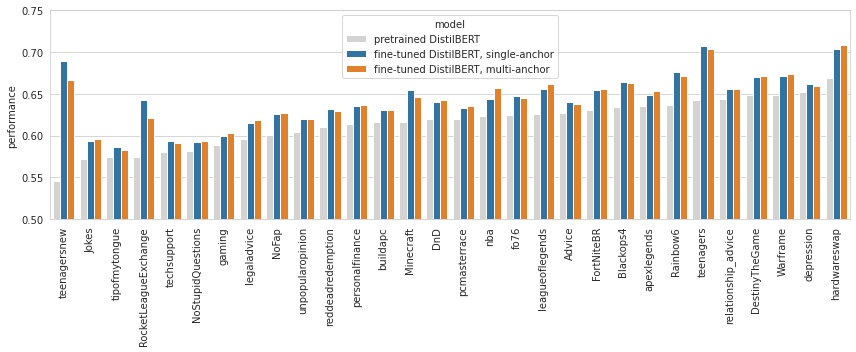

In [6]:
f, ax = plt.subplots(figsize=(12,5))
for i, c in enumerate(['1']):
    sns.barplot(data=ldf[ldf['n_posts']==c],#.sort_vales, 
                x='subreddit', y='accuracy', 
                hue='model', 
                palette=["lightgrey", 
                         *sns.color_palette()[:2]],
                hue_order=['pretrained DistilBERT', 
                           'fine-tuned DistilBERT, single-anchor',
                           'fine-tuned DistilBERT, multi-anchor'])
    plt.ylim(.5,.75)
    plt.xlabel('')
    plt.ylabel('performance')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
data = ldf[ldf['n_posts']=='10'][['model','accuracy','subreddit']].pivot(columns='model', 
                                                               index='subreddit').reset_index()
data.columns = ['subreddit'] + [d[1] for d in data.columns[1:]]
data = data.sort_values(by='fine-tuned DistilBERT, single-anchor', ascending=True)
data.iloc[:,1:] = data.iloc[:,1:].round(3)
data = data[['subreddit'] + list(data.columns[1:][::-1])]

### Plot performance for best baseline, pretrained and trained

In [30]:
losses = []
for c in set(range(0,31)) - set([18]):
    fs = glob.glob(f'../logs/triplet_baselines/single_{c}_*/*/metrics.json')
    for f in fs:
        layers = f.split('/')[-2][1]
        btype = '_'.join(f.split('/')[-3].split('_')[2:])
        try:
            d = json.load(open(f))
            item = {'model': btype,
                    'accuracy': np.mean(d['val_binary_accuracy']),
                    'subreddit': mapping[c],
                    'subreddit_nr': c,
                    'n_posts': '1' if not f.split('/')[-2].split('_')[-1].endswith('10') else '10'}
            losses.append(item)
        except:
            print(f)
ldf2 = pd.DataFrame(losses).sort_values(by='accuracy')
best_baselines = ldf2.groupby(['subreddit_nr', 'n_posts']).agg({'accuracy': 'max'}).reset_index()
best_baselines['model'] = 'best baseline'
perfs = pd.concat([ldf, best_baselines], ignore_index=True).sort_values(by='accuracy')
perfs['model'] = pd.Categorical(perfs['model'], 
                               ['best baseline', 
                                'pretrained DistilBERT', 
                                'fine-tuned DistilBERT, single-anchor',
                                'fine-tuned DistilBERT, multi-anchor'])
perfs['jittered'] = perfs.model.factorize()[0] +  np.random.normal(0, .02, perfs.shape[0])

../logs/triplet_baselines/single_0_bow_100_binary/single_0_bow_100_binary/metrics.json


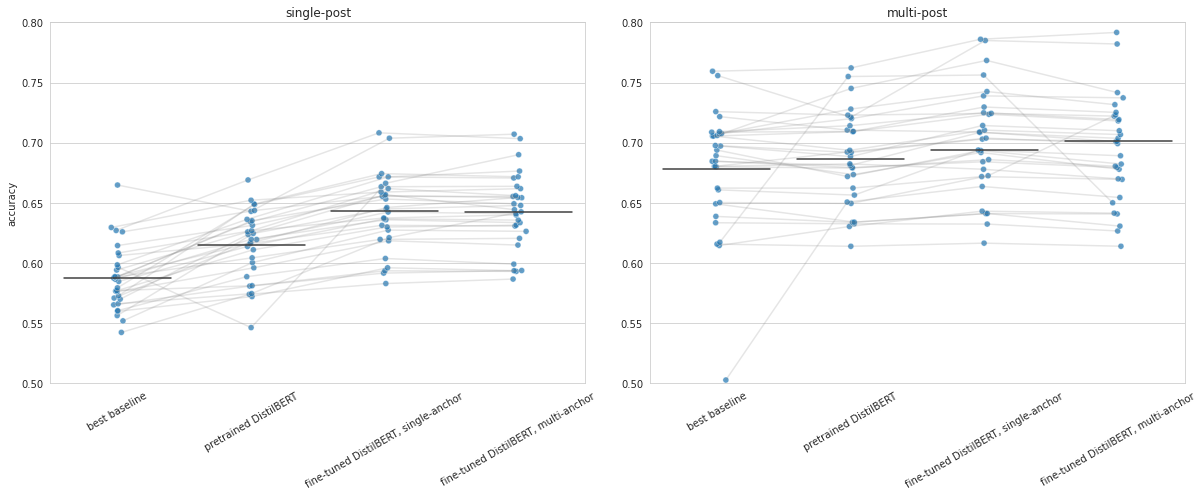

In [31]:
fig, ax = plt.subplots(figsize=(17,7), nrows=1, ncols=2)
titles = ['single-post', 'multi-post']
for i,p in enumerate(['1', '10']):
    sns.lineplot(data=perfs[perfs['n_posts']==p],
                 x='jittered',
                 y='accuracy',
                 hue='subreddit_nr',  
                 markers=True,
                 palette=['grey']*30,
                 legend=False,
                 alpha=.2,
                 ax=ax[i],
                 color='grey')
    sns.scatterplot(data=perfs[perfs['n_posts']==p], 
                    x='jittered',
                    y='accuracy', 
                    hue='model', 
                    palette=[sns.color_palette()[0]]*4,
                    marker='o',
                    legend=False,
                    ax=ax[i], alpha=.7)
    sns.violinplot(data=perfs[perfs['n_posts']==p].groupby('model').accuracy.mean().reset_index(), 
                    x='model',
                    y='accuracy', ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylim(.5,.8)
    ax[i].set_title(titles[i])
    if i==1:
        ax[i].set_ylabel('')
    ax[i].set_xticks(range(4),
                     ['best baseline', 
                      'pretrained DistilBERT', 
                      'fine-tuned DistilBERT, single-anchor',
                      'fine-tuned DistilBERT, multi-anchor'], 
                     rotation=30)
plt.tight_layout()
plt.show()